# **Inner Evaluation: RF and XGB**

## **Requirements**

In [2]:
import polars as pl
import pandas as pd
import numpy as np
import sys
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, KFold
from  xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import pickle
import seaborn as sns
import matplotlib.pyplot as plt 
sns.set_style('whitegrid')

In [3]:
sys.path.insert(0, r'C:\Users\fscielzo\Documents\Packages\BigEDA_Package_Private')
from BigEDA.preprocessing import prop_cols_nulls

In [5]:
sys.path.insert(0, r'C:\Users\fscielzo\Documents\Packages\PyMachineLearning_Package_Private')
from PyMachineLearning.preprocessing import encoder, imputer, scaler, features_selector
from PyMachineLearning.evaluation import SimpleEvaluation

## **Data**

The data set of this project  contains information about Madrid houses extracted from Real State web portals.

The data has been obtained from `Kaggle`:  https://www.kaggle.com/datasets/makofe/housesclean

The following table summarize conceptually the variables contained in the data set with which we will work along this project.

| Variable Name | Description | Type |
|----------|----------|----------|
| `sq_mt_built`    |  size of the house in square meter built   |   Quantitative  |
| `n_rooms`    | Number of rooms of the house     | Quantitative  |
| `n_bathrooms`   |  Number of bathrooms of the house     |  Quantitative  |
| `n_floors`   | Number of floors of the house   |  Quantitative  |
| `sq_mt_allotment`   |   for detached houses, full size including house, pool, garden, etc   |  Quantitative  |
| `floor`   |  Indicates the house height   |  Multiclass  |
| `is_renewal_needed`   |  Indicates wether the house needs renewal or not    |  Binary  |
| `has_lift`   |  Indicates wether the house has lift or not     |  Binary  |
| `is_exterior`   |  Indicates wether the house is exterior or not    |  Binary  |
| `energy_certificate`   |  higher values mean more efficient energy system   |  Multiclass  |
| `has_parking`   |  Indicates wether the house has parking or not   |  Binary  |
| `neighborhood`   |  Madrid's neighborhoods  |  Multiclass  |
| `district`   |  Madrid's districts  |  Multiclass  |
| `house_type`   |  Indicates the house type: flat (0), chalet (1), study (2), duplex (3), top floor (4)  |  Multiclass  |
| `buy_price`   |  The buy price of the house    |  Quantitative  |

In [4]:
madrid_houses_df = pl.read_csv('Data/madrid_houses_NaNS.csv')

In [5]:
variables_to_remove = ['', 'id', 'district', 'neighborhood', 'sq_mt_allotment']
variables_to_keep = [x for x in madrid_houses_df.columns if x not in variables_to_remove]

In [6]:
madrid_houses_df = madrid_houses_df[variables_to_keep]
madrid_houses_df.head()

sq_mt_built,n_rooms,n_bathrooms,n_floors,floor,buy_price,is_renewal_needed,has_lift,is_exterior,energy_certificate,has_parking,house_type
f64,i64,i64,i64,i64,i64,bool,bool,bool,i64,bool,i64
64.0,2,1,1,3,85000,false,false,true,4,false,1
70.0,3,1,1,4,129900,true,true,true,0,false,1
94.0,2,2,1,1,144247,false,true,true,0,false,1
64.0,2,1,1,-1,109900,false,true,true,0,false,1
108.0,2,2,1,4,260000,false,true,true,0,true,1


In [7]:
madrid_houses_df.describe()

describe,sq_mt_built,n_rooms,n_bathrooms,n_floors,floor,buy_price,is_renewal_needed,has_lift,is_exterior,energy_certificate,has_parking,house_type
str,f64,f64,f64,f64,f64,f64,str,str,str,f64,str,f64
"""count""",21739.0,20173.0,21739.0,20626.0,21739.0,21739.0,"""21739""","""21357""","""21739""",21739.0,"""19957""",21739.0
"""null_count""",0.0,1566.0,0.0,1113.0,0.0,0.0,"""0""","""382""","""0""",0.0,"""1782""",0.0
"""mean""",153.81495,3.010063,2.091265,1.233443,1.833249,653572.862045,null,null,null,1.139289,null,1.407746
"""std""",164.718815,1.514733,1.407185,0.709109,3.039869,781966.136859,null,null,null,1.902396,null,1.016465
"""min""",13.0,0.0,1.0,1.0,-5.0,36000.0,"""False""","""False""","""False""",0.0,"""False""",1.0
"""25%""",70.0,2.0,1.0,1.0,1.0,198000.0,null,null,null,0.0,null,1.0
"""50%""",100.0,3.0,2.0,1.0,2.0,375000.0,null,null,null,0.0,null,1.0
"""75%""",165.0,4.0,2.0,1.0,4.0,763000.0,null,null,null,3.0,null,1.0
"""max""",2400.0,24.0,16.0,7.0,10.0,8.8e6,"""True""","""True""","""True""",7.0,"""True""",5.0


In [8]:
prop_cols_nulls(madrid_houses_df)

sq_mt_built,n_rooms,n_bathrooms,n_floors,floor,buy_price,is_renewal_needed,has_lift,is_exterior,energy_certificate,has_parking,house_type
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
0.0,0.072036,0.0,0.051198,0.0,0.0,0.0,0.017572,0.0,0.0,0.081972,0.0


## **Defining the response and predictors**

In [9]:
quant_columns = ['sq_mt_built', 'n_rooms', 'n_bathrooms', 'n_floors', 'buy_price']
cat_columns = [x for x in madrid_houses_df.columns if x not in quant_columns]

response = 'buy_price'
quant_predictors = [x for x in quant_columns if x != response]
cat_predictors = [x for x in cat_columns if x != response]
predictors = quant_predictors + cat_predictors

In [10]:
Y = madrid_houses_df[response].to_pandas()
X = madrid_houses_df[predictors].to_pandas()
# The Null values of the Polars columns that are define as Object type by Pandas are treated as None and not as NaN (what we would like)
# The avoid this behavior the next step is necessary
X = X.fillna(value=np.nan)

## **Defining outer evaluation: train-test split**


In [11]:
# Defining the outer-evaluation: train-test split.
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.90, random_state=123)
# We set a large train size since we are mainly interested in compare models not in estimating the feature performance (indeed, we could omit the test part and doing the inner eval. with the whole data)

## **Defining inner evaluation: K-Fold Cross Validation**

In [12]:
# Defining the inner-evaluation: K-fold cross validation
inner = KFold(n_splits=4, shuffle=True, random_state=123)

## **Pipelines definition**

In [13]:
quant_pipeline = Pipeline([
    ('imputer', imputer()),
    ('scaler', scaler())
    ])

cat_pipeline = Pipeline([
    ('encoder', encoder()), # encoding the categorical variables is needed by some imputers
    ('imputer', imputer())
    ])

quant_cat_transformer = ColumnTransformer(transformers=[('quant', quant_pipeline, quant_predictors),
                                                       ('cat', cat_pipeline, cat_predictors)])

In [14]:
models = {'XGB': XGBRegressor(random_state=123),
          'RF': RandomForestRegressor(random_state=123)}

pipelines = {key: Pipeline([('preprocessing', quant_cat_transformer),
                            ('features_selector', features_selector()),
                            (key, models[key]) 
                           ])         
              for key in models.keys()
            }

## **Grids for HPO**

In [15]:
def preprocessing_param_grid(trial):

    # Fix Grid
    param_grid = {
        'preprocessing__quant__scaler__apply': trial.suggest_categorical('preprocessing__quant__scaler__apply', [True, False]),
        'preprocessing__cat__encoder__method': trial.suggest_categorical('preprocessing__cat__encoder__method', ['ordinal', 'one-hot']),
        'preprocessing__cat__imputer__apply': trial.suggest_categorical('preprocessing__cat__imputer__apply', [True]),
        'preprocessing__quant__imputer__apply': trial.suggest_categorical('preprocessing__quant__imputer__apply', [True]),
        'features_selector__apply': trial.suggest_categorical('features_selector__apply', [False, True])
        }

    # Conditioned Grid

    if param_grid['features_selector__apply'] == True:

        param_grid.update({'features_selector__method': trial.suggest_categorical('features_selector__method', 
                                                                                  ['Fpr_f_reg', 'Fdr_f_reg', 
                                                                                   #'backward_trees_reg', # Takes too much time with one-hot (too many predictors)
                                                                                   #'forward_trees_reg' # Takes too much time with one-hot (too many predictors)
                                                                                   ])})

    if param_grid['preprocessing__quant__scaler__apply'] == True:
    
        param_grid.update({'preprocessing__quant__scaler__method': trial.suggest_categorical('preprocessing__quant__scaler__method', ['standard', 'min-max'])})

    if param_grid['preprocessing__quant__imputer__apply'] == True:

        param_grid.update({'preprocessing__quant__imputer__method': trial.suggest_categorical('preprocessing__quant__imputer__method', ['simple_median', 'iterative_median', 'knn'])})
        param_grid.update({'preprocessing__cat__imputer__method': trial.suggest_categorical('preprocessing__cat__imputer__method', ['simple_most_frequent', 'knn'])})
        
        if  param_grid['preprocessing__quant__imputer__method'] == 'knn':
            param_grid.update({'preprocessing__quant__imputer__n_neighbors': trial.suggest_int('preprocessing__quant__imputer__n_neighbors', 1, 4)})

        if  param_grid['preprocessing__cat__imputer__method'] == 'knn':
            param_grid.update({'preprocessing__cat__imputer__n_neighbors': trial.suggest_int('preprocessing__cat__imputer__n_neighbors', 1, 4)})

        if 'iterative' in param_grid['preprocessing__quant__imputer__method']:
            param_grid.update({'preprocessing__quant__imputer__n_nearest_features': trial.suggest_int('preprocessing__quant__imputer__n_nearest_features', 3, 7)})

        if 'iterative' in param_grid['preprocessing__cat__imputer__method']:
            param_grid.update({'preprocessing__cat__imputer__n_nearest_features': trial.suggest_int('preprocessing__cat__imputer__n_nearest_features', 3, 7)})

    return param_grid

In [16]:
def param_grid_XGB(trial):

    param_grid = preprocessing_param_grid(trial)
    
    param_grid.update({
        'XGB__max_depth': trial.suggest_categorical('XGB__max_depth', [None, 3, 5, 7, 10, 20, 30, 40, 50]),
        'XGB__lambda': trial.suggest_float('XGB__lambda', 0, 0.5, step=0.1, log=False),
        'XGB__n_estimators': trial.suggest_categorical('XGB__n_estimators', [30, 50, 70, 100, 150, 180]),
        'XGB__eta': trial.suggest_float('XGB__eta', 0, 0.3, step=0.02, log=False),
        'XGB__alpha': trial.suggest_float('XGB__alpha', 0.2, 1, step=0.01, log=False)
        })

    return param_grid

In [17]:
def param_grid_RF(trial):

    param_grid = preprocessing_param_grid(trial)

    param_grid.update({
        'RF__n_estimators': trial.suggest_int('RF__n_estimators', 50, 120),
        'RF__max_depth': trial.suggest_categorical('RF__max_depth', [None, 3, 5, 7, 10, 20, 30, 40, 50]),
        'RF__min_samples_split': trial.suggest_int('RF__min_samples_split', 2, 25),
        'RF__min_samples_leaf': trial.suggest_int('RF__min_samples_leaf', 2, 25)
    })

    return param_grid

## **HPO**

In [18]:
inner_score, best_params, inner_results = {}, {}, {}

In [23]:
model_name = 'RF'
param_grid = param_grid_RF

simple_eval = SimpleEvaluation(estimator=pipelines[model_name],  
                               inner=inner, 
                               param_grid=param_grid,
                               search_method='optuna',
                               scoring='neg_mean_absolute_error', 
                               direction='maximize', 
                               n_trials=50, 
                               random_state=666)

simple_eval.fit(X=X_train, y=Y_train)

inner_score[model_name] = simple_eval.inner_score
best_params[model_name] = simple_eval.inner_best_params
inner_results[model_name] = simple_eval.inner_results
# 4.18 mins

[I 2024-04-15 17:26:44,957] A new study created in memory with name: no-name-1a1e0ac2-1944-4460-ac4e-a8f94b15e54c
[I 2024-04-15 17:26:50,760] Trial 0 finished with value: -188890.70900535586 and parameters: {'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'one-hot', 'preprocessing__cat__imputer__apply': True, 'preprocessing__quant__imputer__apply': True, 'features_selector__apply': False, 'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'RF__n_estimators': 102, 'RF__max_depth': 7, 'RF__min_samples_split': 19, 'RF__min_samples_leaf': 10}. Best is trial 0 with value: -188890.70900535586.
[I 2024-04-15 17:27:03,749] Trial 1 finished with value: -184159.34783479813 and parameters: {'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'preprocessing__cat__imputer__apply': True, 'preprocessing__quant__imputer__apply': True, 'features_selector

In [24]:
model_name = 'XGB'
param_grid = param_grid_XGB

simple_eval = SimpleEvaluation(estimator=pipelines[model_name],  
                               inner=inner, 
                               param_grid=param_grid,
                               search_method='optuna',
                               scoring='neg_mean_absolute_error', 
                               direction='maximize', 
                               n_trials=50, 
                               random_state=666)

simple_eval.fit(X=X_train, y=Y_train)

inner_score[model_name] = simple_eval.inner_score
best_params[model_name] = simple_eval.inner_best_params
inner_results[model_name] = simple_eval.inner_results
# 4.18 mins

[I 2024-04-15 17:36:22,375] A new study created in memory with name: no-name-99409745-8e3e-4091-bcf5-e93fe5e66eca
[I 2024-04-15 17:36:24,396] Trial 0 finished with value: -181858.00347698678 and parameters: {'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'one-hot', 'preprocessing__cat__imputer__apply': True, 'preprocessing__quant__imputer__apply': True, 'features_selector__apply': False, 'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'XGB__max_depth': 10, 'XGB__lambda': 0.0, 'XGB__n_estimators': 150, 'XGB__eta': 0.08, 'XGB__alpha': 0.67}. Best is trial 0 with value: -181858.00347698678.
[I 2024-04-15 17:37:03,038] Trial 1 finished with value: -197364.30613706264 and parameters: {'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'one-hot', 'preprocessing__cat__imputer__apply': True, 'preprocessing__quant__imputer__apply': True, 'features_sele

In [27]:
# Saving the results as pickle files
'''
with open(f'classic_results/best_params', 'wb') as file:
    pickle.dump(best_params, file)

with open(f'classic_results/inner_scores', 'wb') as file:
    pickle.dump(inner_score, file)

with open(f'classic_results/inner_results', 'wb') as file:
    pickle.dump(inner_results, file)
'''

In [6]:
# Opening the results 

with open(f'classic_results/best_params', 'rb') as file:
    best_params = pickle.load(file)

with open(f'classic_results/inner_scores', 'rb') as file:
    inner_score = pickle.load(file)

with open(f'classic_results/inner_results', 'rb') as file:
    inner_results = pickle.load(file)

## **Inner results**

In [9]:
inner_score_values = - np.array(list(inner_score.values())) # getting the positive MAE (the original score was negative MAE)
pipelines_names = np.array(list(inner_score.keys()))
best_pipeline = pipelines_names[np.argmin(inner_score_values)]
score_best_pipeline = np.min(inner_score_values)

combined_models_score = list(zip(pipelines_names, inner_score_values))
sorted_combined_models_score= sorted(combined_models_score, key=lambda x: x[1], reverse=False)  # Sort from lower to greater
sorted_pipelines, sorted_scores = zip(*sorted_combined_models_score)
sorted_pipelines = list(sorted_pipelines)
sorted_scores = list(sorted_scores)

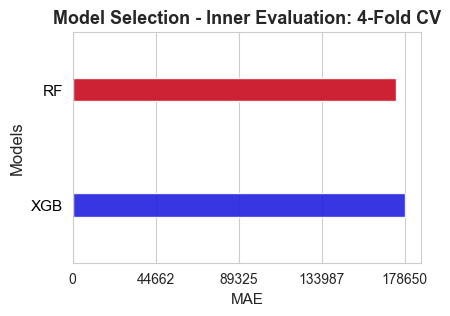

The best model among all the 2 alternatives plotted, according to the inner evaluation, is: RF
MAE of the best model: 173974.755

The best model hyper-parameters are: {'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'preprocessing__cat__imputer__apply': True, 'preprocessing__quant__imputer__apply': True, 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'min-max', 'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__imputer__n_nearest_features': 7, 'RF__n_estimators': 74, 'RF__max_depth': 50, 'RF__min_samples_split': 7, 'RF__min_samples_leaf': 2}


In [15]:
fig, axes = plt.subplots(figsize=(4.5,3))

ax = sns.barplot(y=sorted_pipelines, x=sorted_scores, color='blue', width=0.2, alpha=0.9)
ax = sns.barplot(y=[best_pipeline], x=[score_best_pipeline], color='red', width=0.2, alpha=0.9)

ax.set_ylabel('Models', size=12)
ax.set_xlabel('MAE', size=11)
ax.set_xticks(np.linspace(0, np.max(inner_score_values), 5)) 
ax.tick_params(axis='y', labelsize=11)    
plt.title(f'Model Selection - Inner Evaluation: 4-Fold CV', size=13, weight='bold')
for label in ax.get_yticklabels():
    label.set_color('black') 
plt.show()

print(f'The best model among all the {len(sorted_scores)} alternatives plotted, according to the inner evaluation, is: {best_pipeline}')
print('MAE of the best model:', np.round(score_best_pipeline, 3))
print('\nThe best model hyper-parameters are:', best_params[best_pipeline])

In [11]:
inner_score

{'RF': -173974.7554222493, 'XGB': -178649.63666242664}